# Build a neural network that is designed to learn word usage and context using NLP techniques.

The goal for this data analysis is to see if it is possible to predict if someone has written a positive or negative review of a movie based on their statements by using a sentiment analysis model.

One type of neural network capable of performing text classification is a Deep Learning Neural Network (DNN). “Deep Neural Networks (DNNs) are considered Feed Forward Networks in which data flows from the input layer to the output layer without going backward, and the links between the layers are one-way. This means this process goes forward without touching the node again” (Mohapatra, 2022). A DNN typically contains many hidden networks in between the input and output layers. Each layer applies weights and biases to the data that are learned in the training process. For text classification, the text data needs to be converted to numeric data to be processed by the neural network. This numeric data is fed into the model with an embedding layer before being fed into the following layers.

The following is the exploratory data analysis performed:

1.	The text data was stripped of all non-English characters using regular expressions. The expression used removed everything except letters, numbers, and whitespace. All the text was also converted to lowercase. The following is the code used to do this with annotations:

2.	The vocabulary size was computed using the Tensorflow Tokenizer API. All the words in the data set are converted to tokens by individual word. To get the vocabulary size, we simply find the length of the list of words. The following is the code used to do this with annotations:

3.	For this analysis, the keras Embedding layer was used. “…in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The position of a word in the learned vector space is referred to as its embedding” (Brownlee, 2017). The layer uses the integer data set that was created using the Tokenizer class. The padded token sequences were generated using pad_squences. The following is the code used to do this with annotations:

4.	The maximum sequence length was chosen by finding the longest review by number of words. After the non-English words and characters were removed the longest sequence of words was found and the rest of the sentences are padded to provide a uniform input size for the model. The maximum length found for a review does not cause any significant drain on system memory or training efficiency.

The following are the steps used to prepare the data:

1.	Load the data set from the text file into a pandas Dataframe.
2.	Check the data types and get descriptive statistics.
3.	Check for Null or NA values and fix if necessary.
4.	Check for duplicate values and fix as necessary.
5.	Clean the data by removing non-english characters and symbols.
6.	Get the number of words in the data set and determine the length for padding.
7.	Tokenize the review data.
8.	Split the review and label data into train and test sets with an 80/20 split.
9.	Convert the text sequences into a sequence of integers and add padding to make each sequence the same size.
10.	Convert the label lists into numpy arrays.

The model developed appears to perform at an acceptable level, but it is not optimal. The model is not overfitting, you can see in the loss graph that loss is decreasing to near zero and the value loss stays flat. An optimal model would have both values decreasing to near zero. To prevent overfitting, the early return call back was used along with dropout between hidden layers. Early stopping helps to stop the model from overfitting during training. It works by monitoring a value and stops if that value does not continue to improve. Dropout is a regularization technique that sets a percentage of input units to zero to help prevent overfitting. The model accuracy was assessed using an 80/20 training/testing data set. The model accuracy after training has a training accuracy of 99.75% and test accuracy of 77.5%. I believe the model could be improved by adding more data to the training set.

Brownlee, J. (2017, October 3). How to Use Word Embedding Layers for Deep Learning with Keras. Machine Learning Mastery. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

Mohapatra, S. (2022, November 18). Analyzing and Comparing Deep Learning Models. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2022/11/analyzing-and-comparing-deep-learning-models/


Copyright 2023 by Bryan Cimo see LICENSE for terms.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np  # data manipulation
import pandas as pd  # data manipulation
import re
import matplotlib.pyplot as plt  # visuals
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__, keras.__version__)
%matplotlib inline

2023-09-17 00:54:59.488170: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0 2.10.0


In [3]:
# Import the data set
col_names = ['review', 'label']
data = pd.read_csv('imdb_labelled.txt', sep='\t+', header=None, names=col_names)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [5]:
data.describe()

,label
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [6]:
data.head()

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [7]:
# Check for NA values
data.isna().sum()

review    0
label     0
dtype: int64

In [8]:
# Look for duplicate values.
data.duplicated().any()

True

In [9]:
# Take a look at what's duplicated
duplicate_mask = data.duplicated(keep=False)
data[duplicate_mask]

,review,label
90,Definitely worth checking out.,1
125,10/10,1
363,Definitely worth checking out.,1
572,Not recommended.,0
585,Not recommended.,0
788,10/10,1


In [10]:
# Remove duplicate rows
data = data.drop_duplicates()

In [11]:
# Check new size to confirm duplicates are gone
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  997 non-null    object
 1   label   997 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


In [12]:
# Remove unwanted characters
def clean_text(text):
    # regex to remove all except whitespace and words - also takes out emoji and any non-english characters
    text = re.sub(r'[^a-zA-Z0-9_\s]', '', text)

    # change to lowercase
    text = text.lower()

    return text

In [13]:
data['review'] = data['review'].apply(clean_text)

In [14]:
data.head()

,review,label
0,a very very very slowmoving aimless movie abou...,0
1,not sure who was more lost the flat character...,0
2,attempting artiness with black white and clev...,0
3,very little music or anything to speak of,0
4,the best scene in the movie was when gerardo i...,1


In [15]:
# get the number of words in a string
def word_count(text):
    # split the string into a list
    words = text.split()
    # return the length of the list of words
    return len(words)

In [16]:
# Number of samples to use for training
training_size = int(len(data) * 0.80) # number of periods for testing data 80/20

# Maximum length of the padded sequences
max_length = data['review'].apply(word_count).max()

print('Max length:', max_length)

Max length: 70


In [17]:
# Parameters for padding and OOV tokens
trunc_type='pre'
padding_type='pre'
# out of vocabulary token
oov_token = "<OOV>"

In [18]:
# determine vocabulary size:
tokenizer = Tokenizer(oov_token=oov_token)

# perform tokenization
tokenizer.fit_on_texts(data['review'])

# get all the words and length
word_index_all = tokenizer.word_index
vocab_count = len(word_index_all) + 1 # includes OOV token in count

print('Vocabulary size:',vocab_count)

Vocabulary size: 3175


In [19]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_count)), 0))
print('Max Sequence embedding:', max_sequence_embedding)

Max Sequence embedding: 8


In [20]:
reviews = []
labels = []

# put the data into lists
reviews = data['review'].tolist()
labels = data['label'].tolist()

# split data into train and test sets
train_sentences = reviews[0:training_size]
test_sentences  = reviews[training_size:]
train_labels = labels[0:training_size]
test_labels  = labels[training_size:]

In [21]:
# transform into a sequence of integers
train_sequence = tokenizer.texts_to_sequences(train_sentences)
# add padding to each sequence to make them all the same size
train_padded = pad_sequences(train_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# transform into a sequence of integers
test_sequence = tokenizer.texts_to_sequences(test_sentences)
# add padding to each sequence to make them all the same size
test_padded = pad_sequences(test_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# convert to numpy array
train_labels_np = np.array(train_labels)
test_labels_np = np.array(test_labels)

In [22]:
# export data to csv:
pd.DataFrame(train_padded).to_csv('train_padded.csv')
pd.DataFrame(test_padded).to_csv('test_padded.csv')

In [23]:
# Print the word index
print('Word index:', word_index_all)

print('Sample headline:', train_sentences[1])
print('Sample padded sequence:', train_padded[1])
print('Sample padded shape:', train_padded.shape)

Word index: {'<OOV>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'is': 6, 'this': 7, 'i': 8, 'it': 9, 'to': 10, 'in': 11, 'was': 12, 'movie': 13, 'that': 14, 'film': 15, 'for': 16, 'as': 17, 'but': 18, 'with': 19, 'its': 20, 'one': 21, 'on': 22, 'you': 23, 'are': 24, 'not': 25, 'bad': 26, 'very': 27, 'just': 28, 'so': 29, 'all': 30, 'good': 31, 'at': 32, 'an': 33, 'there': 34, 'about': 35, 'be': 36, 'by': 37, 'have': 38, 'like': 39, 'from': 40, 'if': 41, 'time': 42, 'acting': 43, 'his': 44, 'really': 45, 'or': 46, 'great': 47, 'out': 48, 'even': 49, 'who': 50, 'were': 51, 'he': 52, 'has': 53, 'characters': 54, 'see': 55, 'my': 56, 'most': 57, 'how': 58, 'more': 59, 'no': 60, 'well': 61, 'only': 62, 'movies': 63, 'ever': 64, 'story': 65, 'plot': 66, 'when': 67, 'made': 68, 'some': 69, 'films': 70, 'they': 71, 'dont': 72, 'best': 73, 'because': 74, 'your': 75, 'also': 76, 'can': 77, 'than': 78, 'script': 79, 'other': 80, 'seen': 81, 'way': 82, 'love': 83, 'character': 84, 'make': 85, 'would

In [24]:
# setup for early stopping to help mitigate overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', # value to monitor
    min_delta=0.02, # minimium amount of change to count as an improvement
    patience=8, # how many epochs to wait before stopping
    restore_best_weights=True, # restore model weights from the best epoch
)

# setup the main model
model = tf.keras.Sequential([
    # embedding layer - first layer is setup for input
    layers.Embedding(vocab_count, 32, input_length=max_length),
    # normalization layer
    layers.BatchNormalization(),
    # 1d convolution layer
    layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    # dropout 40% - helps with overfit
    layers.Dropout(0.4),
    # Global max pooling operation for 1D temporal data
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.4), # dropout 40% - helps with overfit
    # densely connected neural network layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4), # dropout 40% - helps with overfit
    layers.Dense(256, activation='relu'), # densely connected neural network layer
    layers.Dropout(0.3), # dropout 40% - helps with overfit
    layers.Dense(128, activation='relu'), # densely connected neural network layer
    layers.Dropout(0.3), # dropout 40% - helps with overfit
    layers.Dense(1, activation='sigmoid') # densely connected neural network layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 32)            101600    
                                                                 
 batch_normalization (BatchN  (None, 70, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 66, 256)           41216     
                                                                 
 dropout (Dropout)           (None, 66, 256)           0         
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [25]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
num_epochs = 30

# fit the model
fit_model = model.fit(train_padded,
                      train_labels_np,
                      epochs=num_epochs,
                      validation_data=(test_padded, test_labels_np),
                      verbose=1,
                      callbacks= early_stopping)

Epoch 1/30
25/25 [==============================] - 1s 22ms/step - loss: 0.7916 - accuracy: 0.5082 - val_loss: 0.6943 - val_accuracy: 0.4300
Epoch 2/30
25/25 [==============================] - 0s 14ms/step - loss: 0.7191 - accuracy: 0.5207 - val_loss: 0.6943 - val_accuracy: 0.4300
Epoch 3/30
25/25 [==============================] - 0s 14ms/step - loss: 0.7097 - accuracy: 0.5282 - val_loss: 0.6938 - val_accuracy: 0.4300
Epoch 4/30
25/25 [==============================] - 0s 13ms/step - loss: 0.7130 - accuracy: 0.4818 - val_loss: 0.6933 - val_accuracy: 0.4300
Epoch 5/30
25/25 [==============================] - 0s 13ms/step - loss: 0.6761 - accuracy: 0.6023 - val_loss: 0.6951 - val_accuracy: 0.4300
Epoch 6/30
25/25 [==============================] - 0s 13ms/step - loss: 0.6296 - accuracy: 0.6537 - val_loss: 0.6967 - val_accuracy: 0.4300
Epoch 7/30
25/25 [==============================] - 0s 12ms/step - loss: 0.4968 - accuracy: 0.7716 - val_loss: 0.6843 - val_accuracy: 0.5450
Epoch 8/30
25

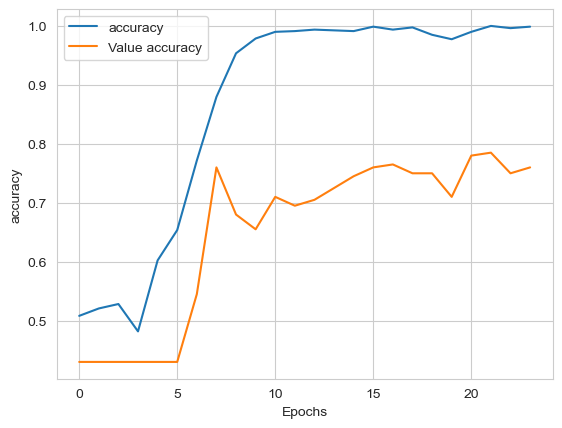

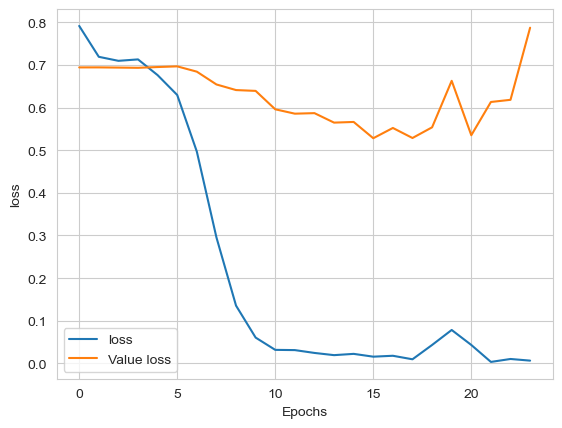

In [27]:
# plot graph
def plot_graph(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'Value ' + string])
    plt.show()

# Plot the accuracy and loss
plot_graph(fit_model, 'accuracy')
plot_graph(fit_model, 'loss')

In [28]:
# evaluate model on training data
train_loss, train_accuracy = model.evaluate(train_padded, train_labels_np, verbose=0)
print('Train Loss:', round(train_loss, 2))
print('Train Accuracy:', round(train_accuracy*100, 2), '%')

# evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_np, verbose=0)
print('Test Loss:', round(test_loss, 2))
print('Test Accuracy:', round(test_accuracy*100, 2), '%')

Train Loss: 0.12
Train Accuracy: 100.0 %
Test Loss: 0.53
Test Accuracy: 76.0 %


In [29]:
# get the index-word dictionary
index_word_dict = tokenizer.index_word

# get the embedding layer from the model
embedding_layer = model.layers[0]

# get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# index-word dictionary
print(index_word_dict)

# print the shape
print(embedding_weights.shape)

{1: '<OOV>', 2: 'the', 3: 'a', 4: 'and', 5: 'of', 6: 'is', 7: 'this', 8: 'i', 9: 'it', 10: 'to', 11: 'in', 12: 'was', 13: 'movie', 14: 'that', 15: 'film', 16: 'for', 17: 'as', 18: 'but', 19: 'with', 20: 'its', 21: 'one', 22: 'on', 23: 'you', 24: 'are', 25: 'not', 26: 'bad', 27: 'very', 28: 'just', 29: 'so', 30: 'all', 31: 'good', 32: 'at', 33: 'an', 34: 'there', 35: 'about', 36: 'be', 37: 'by', 38: 'have', 39: 'like', 40: 'from', 41: 'if', 42: 'time', 43: 'acting', 44: 'his', 45: 'really', 46: 'or', 47: 'great', 48: 'out', 49: 'even', 50: 'who', 51: 'were', 52: 'he', 53: 'has', 54: 'characters', 55: 'see', 56: 'my', 57: 'most', 58: 'how', 59: 'more', 60: 'no', 61: 'well', 62: 'only', 63: 'movies', 64: 'ever', 65: 'story', 66: 'plot', 67: 'when', 68: 'made', 69: 'some', 70: 'films', 71: 'they', 72: 'dont', 73: 'best', 74: 'because', 75: 'your', 76: 'also', 77: 'can', 78: 'than', 79: 'script', 80: 'other', 81: 'seen', 82: 'way', 83: 'love', 84: 'character', 85: 'make', 86: 'would', 87: '

In [30]:
# save the DNN model
model.save('imdb_dnn_classifier.h5')